In [4]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/81 (2).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/58 (11).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/94 (3).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/97 (30).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/93 (1).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/68 (12).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/91 (31).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/91 (35).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/80 (5).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/89 (1).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/88 (6).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/93 (34).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/87 (29).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/92 (6).jpg

In [6]:
# Import necessary libraries
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import torch
from timm import create_model
from imgaug import augmenters as iaa
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)
"""# Step 1: Create Data Generator for Loading and Augmenting Images
def create_data_generator(normal_dir, stroke_dir, target_size=(224, 224), batch_size=32):
    # Collect file paths and labels
    file_paths = []
    labels = []
    class_mapping = {'normal': 0, 'stroke': 1}

    # Normal images
    for img_name in os.listdir(normal_dir):
        img_path = os.path.join(normal_dir, img_name)
        file_paths.append(img_path)
        labels.append(class_mapping['normal'])

    # Stroke images
    for img_name in os.listdir(stroke_dir):
        img_path = os.path.join(stroke_dir, img_name)
        file_paths.append(img_path)
        labels.append(class_mapping['stroke'])

    # Convert to numpy arrays
    file_paths = np.array(file_paths)
    labels = np.array(labels)

    # Balance the dataset
    normal_count = np.sum(labels == 0)
    stroke_count = np.sum(labels == 1)
    print(f"Normal images: {normal_count}, Stroke images: {stroke_count}")

    if normal_count > stroke_count:
        normal_indices = np.where(labels == 0)[0]
        stroke_indices = np.where(labels == 1)[0]
        normal_indices = np.random.choice(normal_indices, stroke_count, replace=False)
        selected_indices = np.concatenate([normal_indices, stroke_indices])
    elif stroke_count > normal_count:
        normal_indices = np.where(labels == 0)[0]
        stroke_indices = np.where(labels == 1)[0]
        stroke_indices = np.random.choice(stroke_indices, normal_count, replace=False)
        selected_indices = np.concatenate([normal_indices, stroke_indices])
    else:
        selected_indices = np.arange(len(labels))

    file_paths = file_paths[selected_indices]
    labels = labels[selected_indices]
    print(f"After balancing - Normal images: {np.sum(labels == 0)}, Stroke images: {np.sum(labels == 1)}")

    # Split the dataset
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=0.3, random_state=42, stratify=labels
    )

    # Define data generators with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        zoom_range=0.1,  # Approximates Gaussian blur effect
        dtype='float32'
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255,
        dtype='float32'
    )

    # Create generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels.astype(str)}),
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels.astype(str)}),
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, val_generator, train_labels, val_labels"""

# Step 1: Load and Preprocess the Dataset with Augmentation
def load_dataset(normal_dir, stroke_dir):
    images = []
    labels = []
    class_mapping = {'normal': 0, 'stroke': 1}
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-10, 10)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    ])
    
    for img_name in os.listdir(normal_dir):
        img_path = os.path.join(normal_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img_rgb)
        labels.append(class_mapping['normal'])
        images_aug = seq.augment_images([img_rgb] * 2)
        images.extend(images_aug)
        labels.extend([class_mapping['normal']] * 2)
    
    for img_name in os.listdir(stroke_dir):
        img_path = os.path.join(stroke_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img_rgb)
        labels.append(class_mapping['stroke'])
        images_aug = seq.augment_images([img_rgb] * 2)
        images.extend(images_aug)
        labels.extend([class_mapping['stroke']] * 2)
    
    images = np.array(images)
    labels = np.array(labels)
    images = images / 255.0
    return images, labels

normal_dir = "/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Normal"
stroke_dir = "/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke"
images, labels = load_dataset(normal_dir, stroke_dir)

# Balance the dataset
normal_count = np.sum(labels == 0)
stroke_count = np.sum(labels == 1)
print(f"Normal images: {normal_count}, Stroke images: {stroke_count}")

if normal_count > stroke_count:
    normal_indices = np.where(labels == 0)[0]
    stroke_indices = np.where(labels == 1)[0]
    normal_indices = np.random.choice(normal_indices, stroke_count, replace=False)
    selected_indices = np.concatenate([normal_indices, stroke_indices])
    images = images[selected_indices]
    labels = labels[selected_indices]
elif stroke_count > normal_count:
    normal_indices = np.where(labels == 0)[0]
    stroke_indices = np.where(labels == 1)[0]
    stroke_indices = np.random.choice(stroke_indices, normal_count, replace=False)
    selected_indices = np.concatenate([normal_indices, stroke_indices])
    images = images[selected_indices]
    labels = labels[selected_indices]

print(f"After balancing - Normal images: {np.sum(labels == 0)}, Stroke images: {np.sum(labels == 1)}")

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

# Step 2: Feature Extraction Using Vision Transformer (ViT)
def extract_vit_features(images, batch_size=32):
    model = create_model(
        'vit_base_patch16_224',
        pretrained=True,
        num_classes=0,
        drop_rate=0.1  # Hyperparameter: dropout rate in ViT
    )
    model.eval()
    model = model.cuda()
    features_list = []
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        images_tensor = torch.tensor(batch_images.transpose(0, 3, 1, 2), dtype=torch.float32).cuda()
        with torch.no_grad():
            batch_features = model(images_tensor)
        features_list.append(batch_features.cpu().numpy())
        torch.cuda.empty_cache()
    features = np.concatenate(features_list, axis=0)
    return features

torch.cuda.empty_cache()
X_train_features = extract_vit_features(X_train, batch_size=32)
X_val_features = extract_vit_features(X_val, batch_size=32)
print(f"ViT feature shape: {X_train_features.shape}")

# Step 3: Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

# Step 4: Feature Selection Using LASSO with Grid Search
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}  # Hyperparameter: LASSO regularization strength
lasso = Lasso(random_state=42)
grid_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_lasso = grid_search.best_estimator_
print(f"Best LASSO alpha: {grid_search.best_params_['alpha']}")

selected_features = np.abs(best_lasso.coef_) > 1e-5
X_train_selected = X_train_scaled[:, selected_features]
X_val_selected = X_val_scaled[:, selected_features]
print(f"Selected feature shape: {X_train_selected.shape}")

# Step 5: Build and Train DenseNet with Learning Rate Tuning
def build_densenet(input_shape, learning_rate=0.001):
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )
    base_model.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Hyperparameter: dropout rate
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)  # Hyperparameter: dropout rate
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),  # Hyperparameter: learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Try multiple learning rates
learning_rates = [0.0001, 0.001, 0.01]
best_val_accuracy = 0
best_model = None
best_lr = None

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = build_densenet(input_shape=(224, 224, 3), learning_rate=lr)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,  # Hyperparameter: batch size
        callbacks=[early_stopping, reduce_lr],
        class_weight={0: 1.0, 1: 1.2},  # Hyperparameter: class weight
        verbose=1
    )
    
    val_accuracy = max(history.history['val_accuracy'])
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_lr = lr

print(f"Best learning rate: {best_lr}")

# Step 6: Evaluate the Best Model
y_pred_prob = best_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Normal images: 4653, Stroke images: 2850
After balancing - Normal images: 2850, Stroke images: 2850


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT feature shape: (3990, 768)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e+01, tolerance: 7.980e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+01, tolerance: 7.980e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+01, tolerance: 7.979e

Best LASSO alpha: 0.001
Selected feature shape: (3990, 529)
Training with learning rate: 0.0001
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1746371295.566918      99 service.cc:148] XLA service 0x79cea00093e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746371295.567619      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746371295.567644      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746371298.519418      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:10:09 34s/step - accuracy: 0.4375 - loss: 0.9594

I0000 00:00:1746371310.755931      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 419ms/step - accuracy: 0.5073 - loss: 0.8496 - val_accuracy: 0.5912 - val_loss: 0.6668 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.5580 - loss: 0.7535 - val_accuracy: 0.6696 - val_loss: 0.6399 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.6012 - loss: 0.7240 - val_accuracy: 0.6901 - val_loss: 0.6123 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.6446 - loss: 0.6912 - val_accuracy: 0.7105 - val_loss: 0.5864 - learning_rate: 1.0000e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.6612 - loss: 0.6723 - val_accuracy: 0.7234 - val_loss: 0.5707 - learning_rate: 1.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.6698 - loss: 0.6675 - val_accuracy: 0.7398 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - 

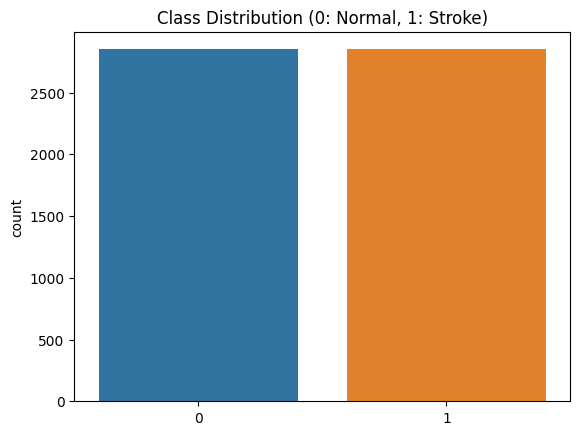

In [7]:
import matplotlib.pyplot as plt#Basic Label Distribution
import seaborn as sns

# Class distribution
sns.countplot(x=labels)
plt.title("Class Distribution (0: Normal, 1: Stroke)")
plt.show()


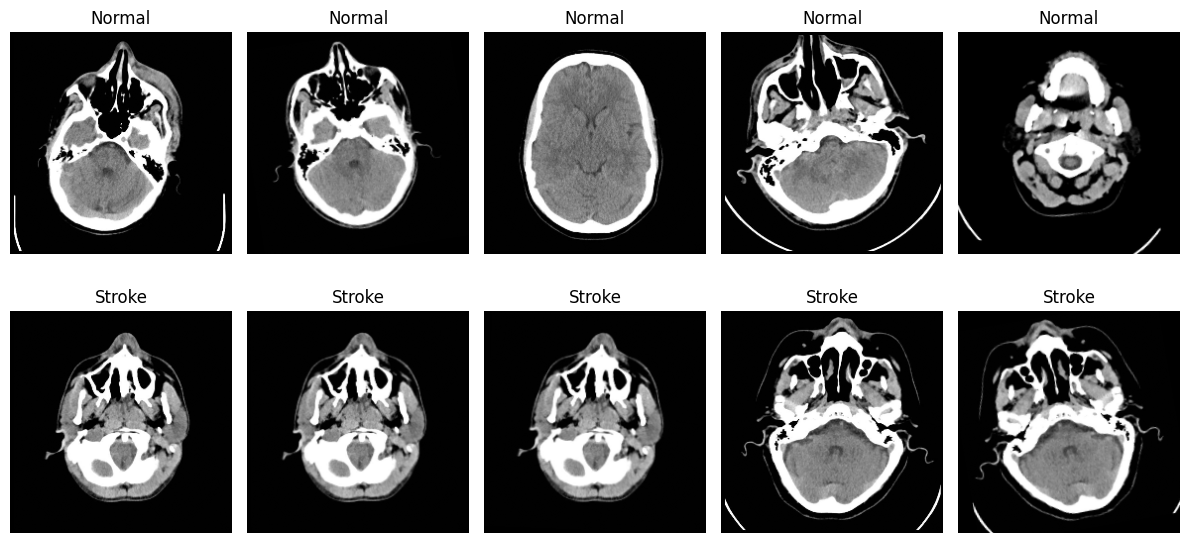

In [8]:
def show_sample_images(images, labels, class_names=["Normal", "Stroke"], num=5):# Show Sample Images from Each Class
    plt.figure(figsize=(12, 6))
    for label in np.unique(labels):
        idxs = np.where(labels == label)[0][:num]
        for i, idx in enumerate(idxs):
            plt.subplot(len(np.unique(labels)), num, label*num + i + 1)
            plt.imshow(images[idx])
            plt.title(class_names[label])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(images, labels)


In [9]:
print(f"Images shape: {images.shape}")#Image Shape, Pixel Stats
print(f"Labels shape: {labels.shape}")
print(f"Pixel range: min={images.min()}, max={images.max()}")
print(f"Mean pixel value: {images.mean():.4f}, Std: {images.std():.4f}")


Images shape: (5700, 224, 224, 3)
Labels shape: (5700,)
Pixel range: min=0.0, max=1.0
Mean pixel value: 0.2088, Std: 0.3219


In [10]:
from imgaug import augmenters as iaa#View augmentation effects

seq = iaa.Sequential([
    iaa.Fliplr(1.0),
    iaa.Affine(rotate=15)
])

img = images[0]  # original image from dataset
aug_img = seq.augment_image(img)

compare_images(img, aug_img, title1="Original", title2="Augmented")


NameError: name 'compare_images' is not defined

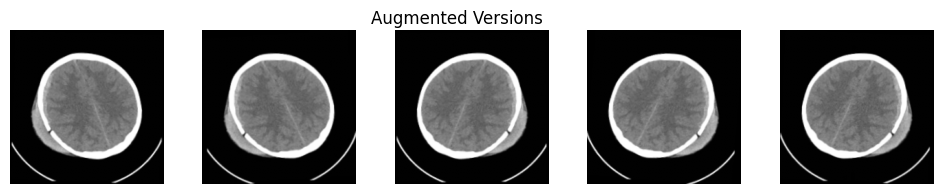

In [11]:
aug_sample = iaa.Sequential([# Visualize Augmentations
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
])

sample_idx = np.random.randint(0, len(images))
original = images[sample_idx]
augmented = aug_sample.augment_images([original] * 5)

plt.figure(figsize=(12, 2))
for i, img in enumerate(augmented):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Augmented Versions")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


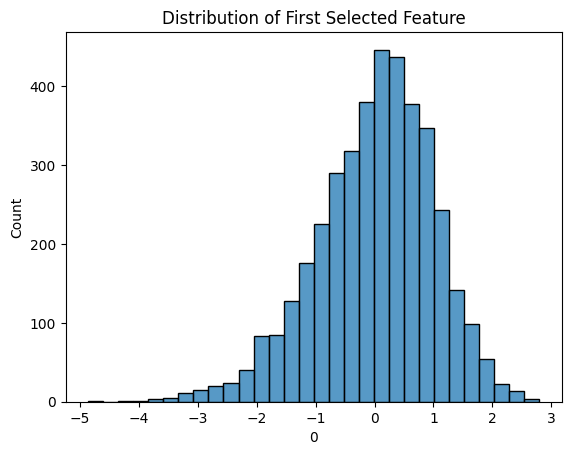

In [12]:
import pandas as pd#Feature Distribution (after ViT + LASSO)

df_features = pd.DataFrame(X_train_selected)
sns.histplot(df_features.iloc[:, 0], bins=30)
plt.title("Distribution of First Selected Feature")
plt.show()


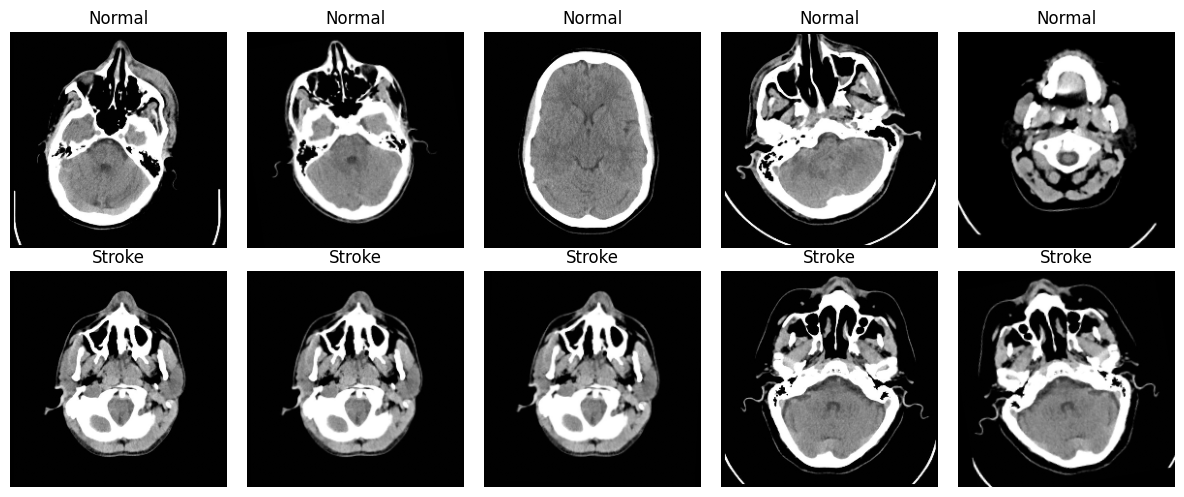

In [13]:
def plot_image_grid(images, labels, class_names=["Normal", "Stroke"], n=5):#Image Grid Samples
    plt.figure(figsize=(12, 5))
    for class_label in np.unique(labels):
        class_idxs = np.where(labels == class_label)[0][:n]
        for i, idx in enumerate(class_idxs):
            plt.subplot(2, n, class_label*n + i + 1)
            plt.imshow(images[idx])
            plt.title(f"{class_names[class_label]}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_image_grid(images, labels)


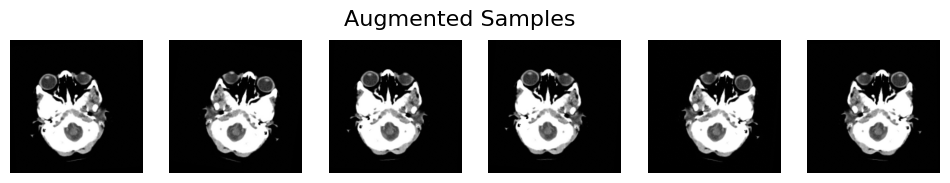

In [14]:
seq = iaa.Sequential([#Augmentation Preview
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
])

img_sample = images[np.random.randint(0, len(images))]
aug_imgs = seq.augment_images([img_sample] * 6)

plt.figure(figsize=(12, 2))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(aug_imgs[i])
    plt.axis("off")
plt.suptitle("Augmented Samples", fontsize=16)
plt.show()


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


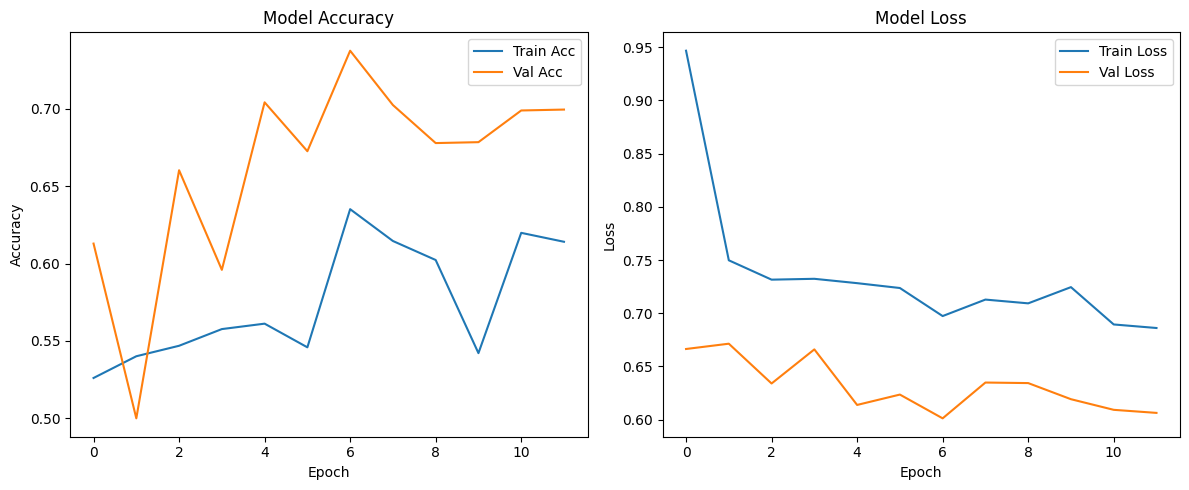

In [16]:
# 5. Accuracy & Loss Curves
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this using the `history` from your best model training
plot_history(history)

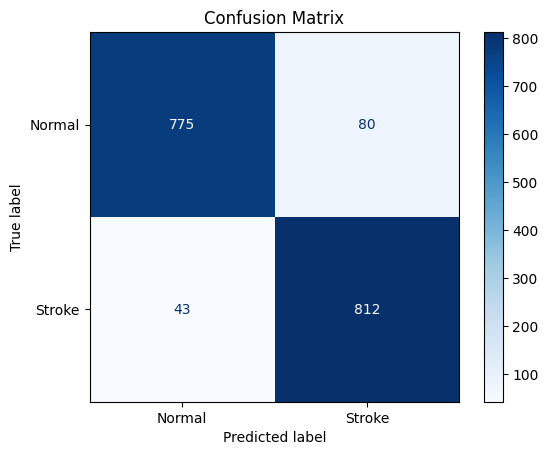

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#Confusion matrix

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Stroke"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [18]:
# Step 7: Save the Best Model
model_save_path = "best_brain_stroke_model.h5"
best_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to best_brain_stroke_model.h5


In [2]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Define paths to test image directories
no_stroke_dir = '/kaggle/input/test-images/Test_images/NoStroke'
stroke_dir = '/kaggle/input/test-images/Test_images/Stroke'

# Define image parameters (adjust these based on your model's requirements)
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Load the saved model (replace 'path_to_your_model.h5' with your model's path)
model = load_model('/kaggle/input/trained-model/best_brain_stroke_model.h5')

# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values

# Load and preprocess test images
test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/test-images/Test_images',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Assuming binary classification (Stroke/NoStroke)
    shuffle=False  # Keep order for evaluation
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Threshold for binary classification

# Get true labels
true_classes = test_generator.classes

# Print classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=['NoStroke', 'Stroke']))

# Print confusion matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))

2025-05-06 13:05:34.002312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746536734.242999      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746536734.308829      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746536749.273573      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746536749.274366      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Found 10 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746536761.970298      96 service.cc:148] XLA service 0x7e870c003260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746536761.971393      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746536761.971414      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746536763.419830      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 1.0000 - loss: 0.1148


I0000 00:00:1746536773.099498      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test Loss: 0.1148
Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Classification Report:
              precision    recall  f1-score   support

    NoStroke       1.00      1.00      1.00         5
      Stroke       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


Confusion Matrix:
[[5 0]
 [0 5]]
